# Create Images with trained GAN models

In [1]:
import torch
import numpy as np
import os,sys,inspect
import matplotlib.pyplot as plt
from configparser import ConfigParser
from torchvision.utils import make_grid, save_image

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import common.setup as setup

### set following variables

In [2]:
model_id = 'DCGAN_MNIST_2020-01-16_12:36' 
#model_id = 'DCGAN_MNIST_2020-01-14_20:50' #'VanillaGAN_MNIST_2020-01-14_18:49'
model_file = 'gen_final_model'
## if auxillary
num_classes = 10

In [3]:
print('setup')
trained_model_directory = os.path.join('..', 'trained_models', model_id)
cf_file = os.path.join(trained_model_directory, 'settings.ini')
config = ConfigParser()
config.read(cf_file)
auxillary = config.getboolean('GAN_HACKS', 'auxillary', fallback=False)
model_type = model_id.split('_')[0]
gen, _ = setup.create_model(config, model_type, num_classes=num_classes if auxillary else 0)
checkpoint = torch.load(os.path.join(trained_model_directory, model_file))
gen.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen.to(device)
print('done')

setup
Initializing weights for DCGenerator
Initializing weights for DCDiscriminator
done


In [4]:
num_images = 10
latent_dim = config.getint('HYPERPARAMS', 'latent_dim')

In [14]:
if auxillary:
    in_labels = torch.zeros((num_classes,num_images)).to(device)
    for i in range(num_classes):
        in_labels[i,:] = i
    in_labels = in_labels.long()
    in_labels = in_labels.view(-1)
    noise = torch.randn((num_images*num_classes, latent_dim), device=device)
    fake_images = gen(in_labels, noise=noise).detach().cpu()/2. + 0.5
else:
    in_noise = torch.normal(torch.zeros(num_images**2, latent_dim), torch.ones(num_images**2, latent_dim)).to(device)
    fake_images = gen(in_noise).detach().cpu()/2. + 0.5

In [15]:
imgs = make_grid(fake_images, nrow=num_images)

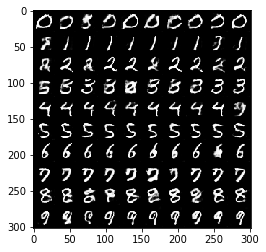

In [16]:
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.savefig(os.path.join('..', 'result_figures', '{:s}.png'.format(model_id)))
plt.show()